# Homework 2 - An Introduction to TensorFlow
## Name: Sondre Kongsgaard
## Collaboration group: Anders Vagle, Brage Saether, Morten Lie

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#from scipy.stats import multivariate_normal
#from numpy.linalg import inv

N = 2000 # Number of samples

def generate_class_0(N):
    m = [0,0]
    C = [[2, 0],[0,1]]
    return np.random.multivariate_normal(m, C, N).T

def generate_class_1(N):
    m_A = [-2,1]
    C_A = [[9.0/8, 7.0/8],[7.0/8, 9.0/8]]
    m_B = [3,2]
    C_B = [[2, 1],[1, 2]]
    
    x1 = np.zeros((2,N))
    for i in range(0, N):
        a = random.uniform(0, 1)
        if (a < 1.0/3):
            x1[:,i] = np.random.multivariate_normal(m_A, C_A, 1)
        else:
            x1[:,i] = np.random.multivariate_normal(m_B, C_B, 1)
    return x1

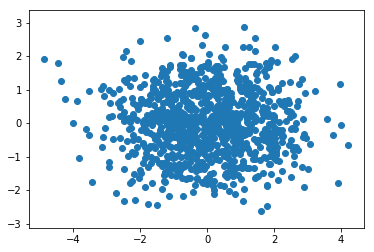

In [2]:
# Class 0, N/2 samples
x0 = generate_class_0(math.floor(N/2))
plt.scatter(x0[0],x0[1])
plt.axis('equal')
plt.show()

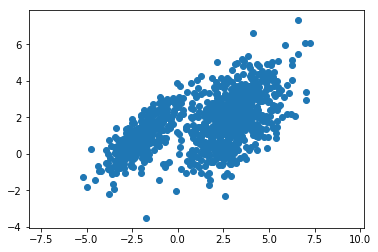

In [3]:
# Class 1, N/2 samples
x1 = generate_class_1(math.floor(N/2))
plt.scatter(x1[0], x1[1])
plt.axis('equal')
plt.show()

In [4]:
# Split the generated data into training, test and validation sets
ratio_training = 0.7
ratio_test = 0.2
ratio_validation = 0.1

x0_training = x0[:,0:math.floor(ratio_training*N/2)]
x0_test = x0[:,math.floor(ratio_training*N/2):(math.floor(ratio_training*N/2)+math.floor(ratio_test*N/2))]
x0_validation = x0[:,(math.floor(ratio_training*N/2)+math.floor(ratio_test*N/2)):]

x1_training = x1[:,0:math.floor(ratio_training*N/2)]
x1_test = x1[:,math.floor(ratio_training*N/2):(math.floor(ratio_training*N/2)+math.floor(ratio_test*N/2))]
x1_validation = x1[:,(math.floor(ratio_training*N/2)+math.floor(ratio_test*N/2)):]

# Combine the data from the two classes, and add labels
x_training = np.concatenate([x0_training, x1_training], axis=1)
x_test = np.concatenate([x0_test, x1_test], axis=1)
x_validation = np.concatenate([x0_validation, x1_validation], axis=1)

y_training = np.append(np.zeros(math.floor(ratio_training*N/2)), np.ones(math.floor(ratio_training*N/2)))
y_test = np.append(np.zeros(math.floor(ratio_test*N/2)), np.ones(math.floor(ratio_test*N/2)))
y_validation = np.append(np.zeros(math.floor(ratio_validation*N/2)), np.ones(math.floor(ratio_validation*N/2)))

# Shuffle the generated data
ind_perm_training = np.random.permutation(len(y_training))
ind_perm_test = np.random.permutation(len(y_test))
ind_perm_validation = np.random.permutation(len(y_validation))

x_training = x_training[:,ind_perm_training]
x_test = x_test[:,ind_perm_test]
x_validation = x_validation[:,ind_perm_validation]

y_training = y_training[ind_perm_training]
y_test = y_test[ind_perm_test]
y_validation = y_validation[ind_perm_validation]

# 1a) Fully connected neural network with **1** hidden layer
## ReLU nonlinearities are used in the layers, a sigmoid at the output, and with binary cross entropy as the loss function

In [5]:
# Fully connected neural network with 2 hidden layers
# ReLU nonlinearities are used in the layers, a sigmoid at the output,
# and with binary cross entropy as the loss function

# Parameters
learning_rate = 0.01
num_steps = int(N*0.7)
num_epochs = 20
batch_size = 10
reg_const = 0.01

# Network Parameters
n_hidden = 10 # 1st layer number of neurons
num_input = 2
num_classes = 1

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [6]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 10 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Add ReLU nonlinearity
    layer_1 = tf.nn.relu(layer_1)
    
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

In [7]:
# Construct model
logits = neural_net(X)
prediction = tf.nn.sigmoid(logits)
prediction = tf.cast(tf.greater(prediction, 1/2), tf.float32)

# Define loss and optimizer
cross_entropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y)
reg_loss = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['out']) # L2 regularization
loss_op = tf.reduce_mean(cross_entropy_loss + reg_const*reg_loss)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(prediction, Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [8]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for epoch in range(num_epochs):
        ind_perm_validation = np.random.permutation(len(y_validation))
        x_training = x_training[:,ind_perm_training]
        y_training = y_training[ind_perm_training]
        
        for batch in range(0, num_steps, batch_size):
            batch_x = x_training[:,batch:batch+batch_size].T
            batch_y = y_training[batch:batch+batch_size].reshape([-1,1])
            
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})

        # Calculate accuracy for test data
        test_acc = sess.run(accuracy, feed_dict={X: x_test.T, Y: y_test.reshape([-1,1])})
        validation_acc = sess.run(accuracy, feed_dict={X: x_validation.T, Y: y_validation.reshape([-1,1])})
        print("Epoch {:2d}, Testing Accuracy: {:.2f} Validation Accuracy: {:.2f}"
              .format(epoch+1, test_acc, validation_acc))
            
    print("Optimization Finished!")

Epoch  1, Testing Accuracy: 0.85 Validation Accuracy: 0.81
Epoch  2, Testing Accuracy: 0.85 Validation Accuracy: 0.84
Epoch  3, Testing Accuracy: 0.86 Validation Accuracy: 0.82
Epoch  4, Testing Accuracy: 0.84 Validation Accuracy: 0.83
Epoch  5, Testing Accuracy: 0.84 Validation Accuracy: 0.84
Epoch  6, Testing Accuracy: 0.84 Validation Accuracy: 0.81
Epoch  7, Testing Accuracy: 0.84 Validation Accuracy: 0.83
Epoch  8, Testing Accuracy: 0.84 Validation Accuracy: 0.84
Epoch  9, Testing Accuracy: 0.85 Validation Accuracy: 0.85
Epoch 10, Testing Accuracy: 0.86 Validation Accuracy: 0.85
Epoch 11, Testing Accuracy: 0.85 Validation Accuracy: 0.83
Epoch 12, Testing Accuracy: 0.85 Validation Accuracy: 0.82
Epoch 13, Testing Accuracy: 0.85 Validation Accuracy: 0.84
Epoch 14, Testing Accuracy: 0.85 Validation Accuracy: 0.86
Epoch 15, Testing Accuracy: 0.85 Validation Accuracy: 0.83
Epoch 16, Testing Accuracy: 0.85 Validation Accuracy: 0.82
Epoch 17, Testing Accuracy: 0.84 Validation Accuracy: 0.

# 1b) Fully connected neural network with **2** hidden layers
## ReLU nonlinearities are used in the layers, a sigmoid at the output, and with binary cross entropy as the loss function

In [9]:
# Fully connected neural network with 2 hidden layers
# ReLU nonlinearities are used in the layers, a sigmoid at the output,
# and with binary cross entropy as the loss function

# Parameters
learning_rate = 0.01
num_steps = int(N*0.7)
num_epochs = 20
batch_size = 10
reg_const = 0.01

# Network Parameters
n_hidden_1 = 10 # 1st layer number of neurons
n_hidden_2 = 10 # 2nd layer number of neurons
num_input = 2
num_classes = 1

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [10]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 10 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Add ReLU nonlinearity
    layer_1 = tf.nn.relu(layer_1)
    
    # Hidden fully connected layer with 10 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Add ReLU nonlinearity
    layer_2 = tf.nn.relu(layer_2)
    
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [11]:
# Construct model
logits = neural_net(X)
prediction = tf.nn.sigmoid(logits)
prediction = tf.cast(tf.greater(prediction, 1/2), tf.float32)

# Define loss and optimizer
cross_entropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y)
reg_loss = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['out']) # L2 regularization
loss_op = tf.reduce_mean(cross_entropy_loss + reg_const*reg_loss)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(prediction, Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [12]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for epoch in range(num_epochs):
        ind_perm_validation = np.random.permutation(len(y_validation))
        x_training = x_training[:,ind_perm_training]
        y_training = y_training[ind_perm_training]
        
        for batch in range(0, num_steps, batch_size):
            batch_x = x_training[:,batch:batch+batch_size].T
            batch_y = y_training[batch:batch+batch_size].reshape([-1,1])
            
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            
        # Calculate accuracy for test data
        test_acc = sess.run(accuracy, feed_dict={X: x_test.T, Y: y_test.reshape([-1,1])})
        validation_acc = sess.run(accuracy, feed_dict={X: x_validation.T, Y: y_validation.reshape([-1,1])})
        print("Epoch {:2d}, Testing Accuracy: {:.2f} Validation Accuracy: {:.2f}"
              .format(epoch+1, test_acc, validation_acc))

    print("Optimization Finished!")

Epoch  1, Testing Accuracy: 0.81 Validation Accuracy: 0.83
Epoch  2, Testing Accuracy: 0.85 Validation Accuracy: 0.81
Epoch  3, Testing Accuracy: 0.83 Validation Accuracy: 0.80
Epoch  4, Testing Accuracy: 0.83 Validation Accuracy: 0.83
Epoch  5, Testing Accuracy: 0.85 Validation Accuracy: 0.82
Epoch  6, Testing Accuracy: 0.86 Validation Accuracy: 0.84
Epoch  7, Testing Accuracy: 0.86 Validation Accuracy: 0.82
Epoch  8, Testing Accuracy: 0.82 Validation Accuracy: 0.83
Epoch  9, Testing Accuracy: 0.85 Validation Accuracy: 0.85
Epoch 10, Testing Accuracy: 0.84 Validation Accuracy: 0.81
Epoch 11, Testing Accuracy: 0.83 Validation Accuracy: 0.83
Epoch 12, Testing Accuracy: 0.84 Validation Accuracy: 0.84
Epoch 13, Testing Accuracy: 0.85 Validation Accuracy: 0.82
Epoch 14, Testing Accuracy: 0.85 Validation Accuracy: 0.83
Epoch 15, Testing Accuracy: 0.85 Validation Accuracy: 0.83
Epoch 16, Testing Accuracy: 0.85 Validation Accuracy: 0.85
Epoch 17, Testing Accuracy: 0.85 Validation Accuracy: 0.

# 2) 
For the results above, 0.7\*1000 training data samples are used for each class, and 0.1\*1000 for validation samples.
Increasing the number of samples stabilized the accuracy of the classification, and generally allowed for it to be higher. 

The weights used seem to have a limited impact on the accuracy. As long as the learning rate isn't to high, tweaking the other parameters have in my experience still kept the accuracy over 0.7. Therefore I stopped tweaking the parameters, and just rounded them off to some reasonably low round numbers.

We see from the printed output from each epoch that the accuracy is high even after epoch 1, which implies that this is a simple data set to train.

The final classification accuracy is ~0.83 (when using either 1 or 2 hidden layers)

With the variant of the data model, where the mean of class 1 is doubled, the accuracy is ~98% (again for using either 1 or 2 hidden layers). 

# 3) 
*Input preprocessing:* 

- Scaling to zero mean. Subtract the mean from every feature in the data.
- Scaling to unit variance. Scale the data so their dimensions are more or less the same. Useful if the data has different scales where it is desired that each scale should be weighted equally during training.
    
*Weight initialization:* 

It is undesirable to start with all zero initialized weights, as then there will be no source for asymmetry for the following training. Therefore, weights are typically drawn from a gaussian distribution, that are then multiplied by a small number. The numbers could also be drawn from a uniform distribution, but typically this does not have much impact on the performance. A problem with this approach though, is that the variance grows with the number of inputs.
A normalization could be done to account for this. For instance one could divide the random weights by the square root of the number of inputs.

# 4)
I got more or less the same accuracy for all methods used in homework 1, i.e. MAP, kernelized logistic regression and logistic regression with explicit feature engineering. For all of them the accuracy was ~85%, which is about the same as the results shown above when using a fully connected neural network. 

However, running through the neural network is much faster than the other methods, and in particular the logistic regression.